In [1]:
import scanpy as sc

In [30]:
ctrl_1 = sc.read_csv("./data/GSM5226574_C51ctr_raw_counts.csv").T
ctrl_1

AnnData object with n_obs × n_vars = 6099 × 34546

In [17]:
ctrl_1.obs.head()

""
TAGGTACCATGGCCAC-1_1
ATTCACTGTAACAGGC-1_1
TAACTTCCAACCACGC-1_1
TTGGGTACACGACAAG-1_1
AGGCCACAGAGTCACG-1_1


In [19]:
ctrl_1.var.head()

""
AL627309.1
AL627309.5
AL627309.4
AL669831.2
LINC01409


### Doublet removal

We predict whether a barcode is a doublet or not based on scvi's autoencoder.

In [31]:
import scvi

sc.pp.filter_genes(ctrl_1, min_cells=10)
print("Shape after filtering genes:", ctrl_1.shape)
sc.pp.highly_variable_genes(
    ctrl_1,
    n_top_genes=2000,
    subset=True,
    flavor="seurat_v3",
)
print("Shape after selecting highly variable genes:", ctrl_1.shape)
scvi.model.SCVI.setup_anndata(ctrl_1)
vae = scvi.model.SCVI(ctrl_1)
vae.train()

Shape after filtering genes: (6099, 19896)


/Users/amkhrjee/Developer/covid-lung-atlas/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/amkhrjee/Developer/covid-lung-atlas/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/amkhrjee/Developer/covid-lung-atlas/.venv/lib/python3.13/site-packages

Shape after selecting highly variable genes: (6099, 2000)
Epoch 400/400: 100%|██████████| 400/400 [08:36<00:00,  1.15it/s, v_num=1, train_loss=324]  

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [08:36<00:00,  1.29s/it, v_num=1, train_loss=324]


In [32]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/amkhrjee/Developer/covid-lung-atlas/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/amkhrjee/Developer/covid-lung-atlas/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/amkhrjee/Developer/covid-lung-atlas/.venv/lib/python3.13/site-packages

Epoch 154/400:  38%|███▊      | 154/400 [00:22<00:36,  6.74it/s, v_num=1, train_loss_step=0.303, train_loss_epoch=0.293]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.272. Signaling Trainer to stop.


In [ ]:
df = solo.predict()
df["prediction"] = solo.predict(soft=False)

df

/Users/amkhrjee/Developer/covid-lung-atlas/.venv/lib/python3.13/site-packages/torch/utils/_contextlib.py:124: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabilities. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/amkhrjee/Developer/covid-lung-atlas/.venv/lib/python3.13/site-packages/torch/utils/_contextlib.py:124: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabilities. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
TAGGTACCATGGCCAC-1_1,0.931696,0.068305,doublet
ATTCACTGTAACAGGC-1_1,0.790771,0.209229,doublet
TAACTTCCAACCACGC-1_1,0.617929,0.382071,doublet
TTGGGTACACGACAAG-1_1,0.891029,0.108971,doublet
AGGCCACAGAGTCACG-1_1,0.784657,0.215343,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1_1,0.032631,0.967369,singlet
CACTGGGGTCTACGTA-1_1,0.000359,0.999641,singlet
CATACTTGTAGAGGAA-1_1,0.002466,0.997534,singlet
TTTGGTTTCCACGGAC-1_1,0.001602,0.998398,singlet


In [35]:
df.groupby("prediction").count()

,doublet,singlet
prediction,,
doublet,1232,1232
singlet,4867,4867


In [42]:
singlet_indices = df[df["prediction"] == "singlet"].index
print("Indices where prediction is 'singlet':")
print(singlet_indices)

Indices where prediction is 'singlet':
Index(['TTGGTTTTCCTAGCTC-1_1', 'CGCATAACATGCCGGT-1_1', 'CTGTAGATCAACGTGT-1_1',
       'CCTTGTGCAGAGGGTT-1_1', 'AAGTTCGCAACACGTT-1_1', 'CAACCAAAGTATTCCG-1_1',
       'AACGGGACATGCCGGT-1_1', 'TATATCCAGCGTCAGA-1_1', 'AGACAAACATCCCGTT-1_1',
       'GAATCGTCAGAAGTGC-1_1',
       ...
       'AAGTCGTGTGTGAATA-1_1', 'GTCGTTCTCCAAGGGA-1_1', 'GTTTGGATCGGCCTTT-1_1',
       'GTACAGTCACGTATAC-1_1', 'TCATGCCCAAGAGGTC-1_1', 'CGCCATTGTTTGCCGG-1_1',
       'CACTGGGGTCTACGTA-1_1', 'CATACTTGTAGAGGAA-1_1', 'TTTGGTTTCCACGGAC-1_1',
       'ATGCATGAGTCATGAA-1_1'],
      dtype='object', length=4867)


In [45]:
singlet_only_ctrl1 = ctrl_1[singlet_indices]
singlet_only_ctrl1

View of AnnData object with n_obs × n_vars = 4867 × 2000
    obs: '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'

### Removing mitochondrial genes

For humans, mitochrondrial genes start with `MT-`.

In [ ]:
singlet_only_ctrl1.var

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
TTLL10,112,True,903.0,0.028857,0.069354,1.901045
TNFRSF18,15,True,1604.0,0.002951,0.004911,1.513808
CFAP74,159,True,1370.0,0.041154,0.087024,1.607399
TTC34,209,True,245.0,0.080341,0.363502,3.044086
AJAP1,31,True,1922.0,0.006886,0.011432,1.421002
...,...,...,...,...,...,...
MT-ND4L,650,True,1212.0,0.191671,0.559353,1.695637
MT-ND4,1328,True,178.0,0.833087,9.742224,3.486984
MT-ND5,886,True,443.0,0.332514,1.669344,2.430210
MT-ND6,821,True,123.0,0.383178,3.357087,3.985056


In [54]:
singlet_only_ctrl1.var["is_mito_gene"] = singlet_only_ctrl1.var.index.str.startswith(
    "MT-"
)

/var/folders/ff/4kc7g2h15bs_kbkzfbs381r00000gn/T/ipykernel_41038/4227380845.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  singlet_only_ctrl1.var["is_mito_gene"] = singlet_only_ctrl1.var.index.str.startswith(


In [55]:
singlet_only_ctrl1.var

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,is_mito_gene
TTLL10,112,True,903.0,0.028857,0.069354,1.901045,False
TNFRSF18,15,True,1604.0,0.002951,0.004911,1.513808,False
CFAP74,159,True,1370.0,0.041154,0.087024,1.607399,False
TTC34,209,True,245.0,0.080341,0.363502,3.044086,False
AJAP1,31,True,1922.0,0.006886,0.011432,1.421002,False
...,...,...,...,...,...,...,...
MT-ND4L,650,True,1212.0,0.191671,0.559353,1.695637,True
MT-ND4,1328,True,178.0,0.833087,9.742224,3.486984,True
MT-ND5,886,True,443.0,0.332514,1.669344,2.430210,True
MT-ND6,821,True,123.0,0.383178,3.357087,3.985056,True


### Removing ribosomal genes

We use a list of known ribosomal genes from the Broad Institute to eliminate them from our matrix.

In [ ]:
import pandas as pd

ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)
ribo_genes.head()

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L


In [57]:
singlet_only_ctrl1.var["is_ribo_gene"] = singlet_only_ctrl1.var.index.isin(
    ribo_genes[0]
)
singlet_only_ctrl1.var

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,is_mito_gene,is_ribo_gene
TTLL10,112,True,903.0,0.028857,0.069354,1.901045,False,False
TNFRSF18,15,True,1604.0,0.002951,0.004911,1.513808,False,False
CFAP74,159,True,1370.0,0.041154,0.087024,1.607399,False,False
TTC34,209,True,245.0,0.080341,0.363502,3.044086,False,False
AJAP1,31,True,1922.0,0.006886,0.011432,1.421002,False,False
...,...,...,...,...,...,...,...,...
MT-ND4L,650,True,1212.0,0.191671,0.559353,1.695637,True,False
MT-ND4,1328,True,178.0,0.833087,9.742224,3.486984,True,False
MT-ND5,886,True,443.0,0.332514,1.669344,2.430210,True,False
MT-ND6,821,True,123.0,0.383178,3.357087,3.985056,True,False


In [58]:
print("Number of ribosomal genes:", singlet_only_ctrl1.var["is_ribo_gene"].sum())
print("Number of mitochondrial genes:", singlet_only_ctrl1.var["is_mito_gene"].sum())

Number of ribosomal genes: 29
Number of mitochondrial genes: 13


In [59]:
singlet_only_ctrl1.obs

,_scvi_batch,_scvi_labels
TTGGTTTTCCTAGCTC-1_1,0,0
CGCATAACATGCCGGT-1_1,0,0
CTGTAGATCAACGTGT-1_1,0,0
CCTTGTGCAGAGGGTT-1_1,0,0
AAGTTCGCAACACGTT-1_1,0,0
...,...,...
CGCCATTGTTTGCCGG-1_1,0,0
CACTGGGGTCTACGTA-1_1,0,0
CATACTTGTAGAGGAA-1_1,0,0
TTTGGTTTCCACGGAC-1_1,0,0


In [ ]:
sc.pp.calculate_qc_metrics(
    singlet_only_ctrl1,
    qc_vars=["is_mito_gene", "is_ribo_gene"],
    inplace=True,
    log1p=False,
)
singlet_only_ctrl1.obs

,_scvi_batch,_scvi_labels,n_genes_by_counts,total_counts,total_counts_is_mito_gene,pct_counts_is_mito_gene,total_counts_is_ribo_gene,pct_counts_is_ribo_gene,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
TTGGTTTTCCTAGCTC-1_1,0,0,283,2259.0,463.0,20.495794,4.0,0.177070,66.666667,82.647189,96.104471,100.000000
CGCATAACATGCCGGT-1_1,0,0,521,2469.0,119.0,4.819765,11.0,0.445525,44.430944,61.239368,79.910895,99.149453
CTGTAGATCAACGTGT-1_1,0,0,527,2912.0,1.0,0.034341,0.0,0.000000,45.192308,61.847527,79.773352,99.072802
CCTTGTGCAGAGGGTT-1_1,0,0,267,1917.0,575.0,29.994783,2.0,0.104330,68.857590,83.411581,96.504956,100.000000
AAGTTCGCAACACGTT-1_1,0,0,275,1578.0,6.0,0.380228,0.0,0.000000,66.286439,81.178707,95.247148,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,0,0,100,131.0,3.0,2.290076,0.0,0.000000,61.832061,100.000000,100.000000,100.000000
CACTGGGGTCTACGTA-1_1,0,0,43,68.0,0.0,0.000000,0.0,0.000000,100.000000,100.000000,100.000000,100.000000
CATACTTGTAGAGGAA-1_1,0,0,21,24.0,2.0,8.333334,0.0,0.000000,100.000000,100.000000,100.000000,100.000000
TTTGGTTTCCACGGAC-1_1,0,0,35,51.0,0.0,0.000000,2.0,3.921569,100.000000,100.000000,100.000000,100.000000


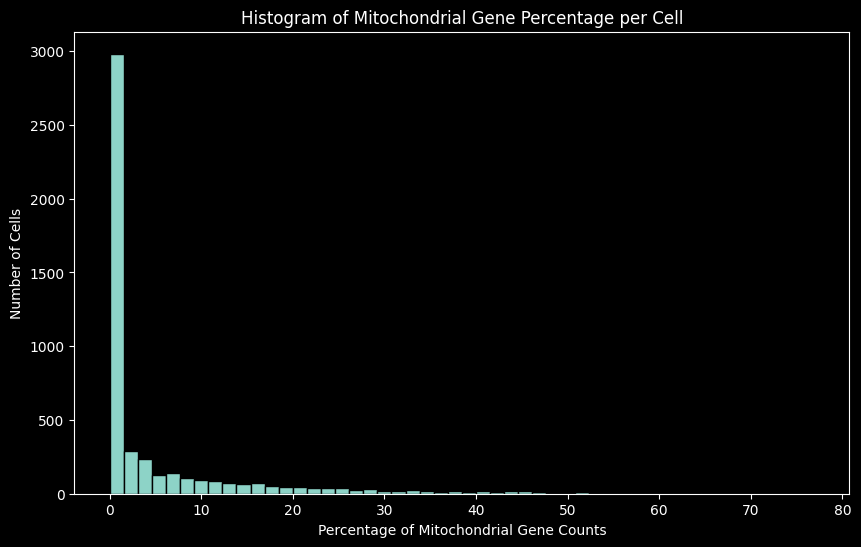

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(singlet_only_ctrl1.obs["pct_counts_is_mito_gene"], bins=50, edgecolor="black")
plt.xlabel("Percentage of Mitochondrial Gene Counts")
plt.ylabel("Number of Cells")
plt.title("Histogram of Mitochondrial Gene Percentage per Cell")
plt.show()

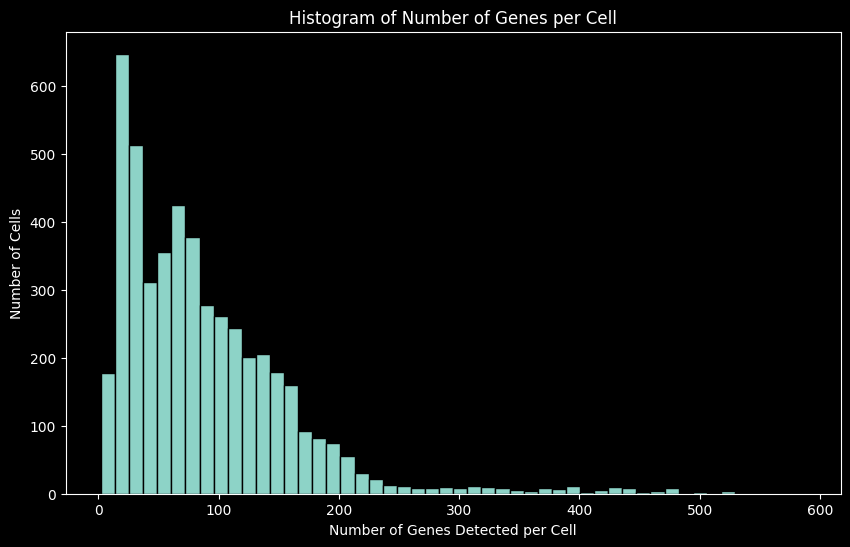

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(singlet_only_ctrl1.obs["n_genes_by_counts"], bins=50, edgecolor="black")
plt.xlabel("Number of Genes Detected per Cell")
plt.ylabel("Number of Cells")
plt.title("Histogram of Number of Genes per Cell")
plt.show()

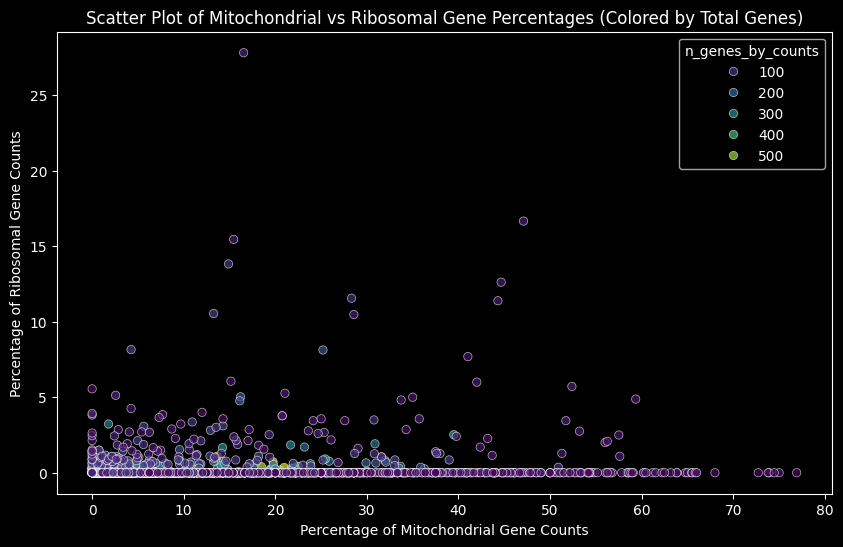

In [71]:
# Plot scatter plot of mito percentage vs ribo percentage, colored by total genes
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=singlet_only_ctrl1.obs,
    x="pct_counts_is_mito_gene",
    y="pct_counts_is_ribo_gene",
    hue="n_genes_by_counts",
    palette="viridis",
    alpha=0.7,
)
plt.xlabel("Percentage of Mitochondrial Gene Counts")
plt.ylabel("Percentage of Ribosomal Gene Counts")
plt.title(
    "Scatter Plot of Mitochondrial vs Ribosomal Gene Percentages (Colored by Total Genes)"
)
plt.show()

In [ ]:
singlet_only_ctrl1.var.f

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,is_mito_gene,is_ribo_gene,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
NEAT1,4546,True,1569.0,5.314150,104.575941,1.524690,False,False,3445,4.320937,29.217177,21030.0
ANK3,2522,True,1456.0,2.236924,22.783969,1.570576,False,False,1857,1.772755,61.845079,8628.0
FTO,2284,True,1282.0,0.695196,3.469723,1.654960,False,False,1606,0.560304,67.002260,2727.0
PRKG1,2170,True,973.0,2.086899,23.688413,1.841435,False,False,1571,1.635093,67.721389,7958.0
ALCAM,2163,True,1742.0,1.906378,16.173752,1.468978,False,False,1551,1.511403,68.132320,7356.0
...,...,...,...,...,...,...,...,...,...,...,...,...
LINC01173,10,True,1387.0,0.002295,0.003930,1.599655,False,False,4,0.001438,99.917814,7.0
AC023796.1,12,True,1931.0,0.002459,0.003766,1.418272,False,False,4,0.000822,99.917814,4.0
CLCA2,11,True,949.0,0.002787,0.006716,1.859552,False,False,4,0.001027,99.917814,5.0
LINC01994,11,True,1025.0,0.002951,0.005895,1.817107,False,False,3,0.001233,99.938360,6.0


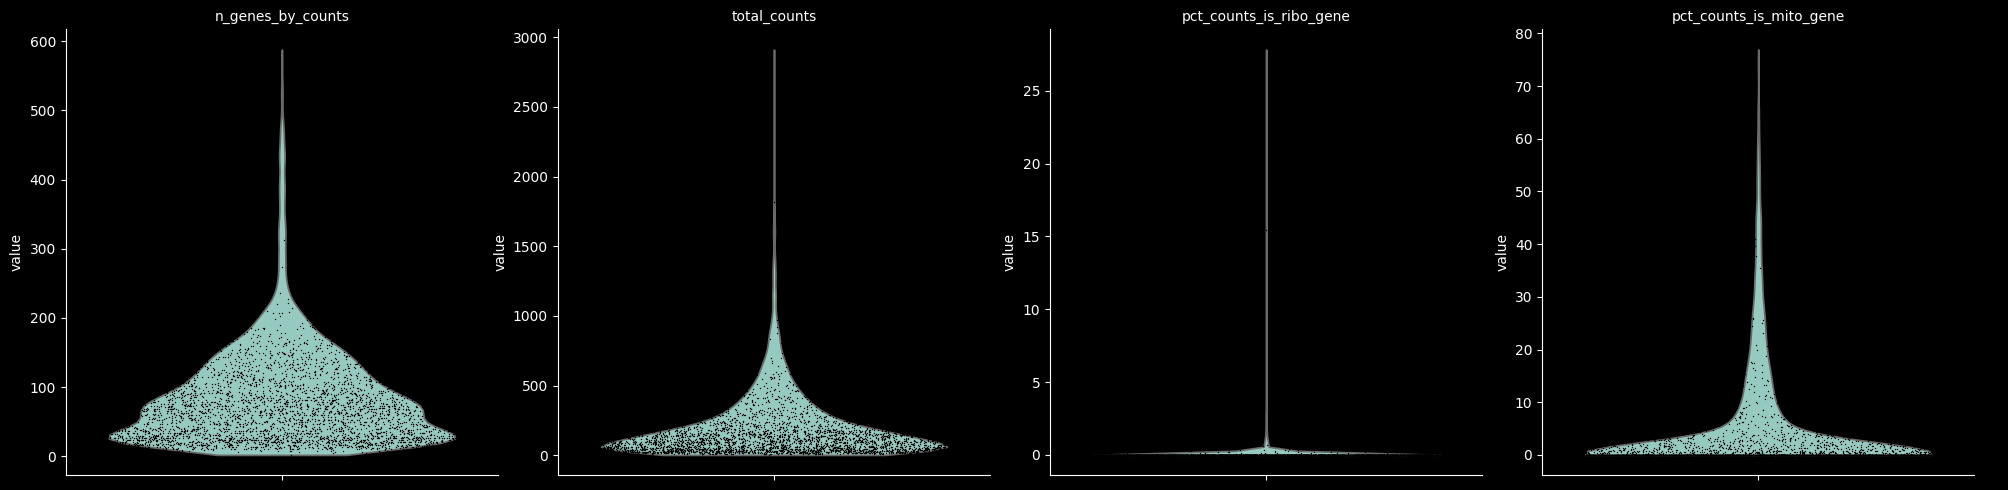

In [76]:
sc.pl.violin(
    singlet_only_ctrl1,
    [
        "n_genes_by_counts",
        "total_counts",
        "pct_counts_is_ribo_gene",
        "pct_counts_is_mito_gene",
    ],
    multi_panel=True,
    jitter=0.4,
)

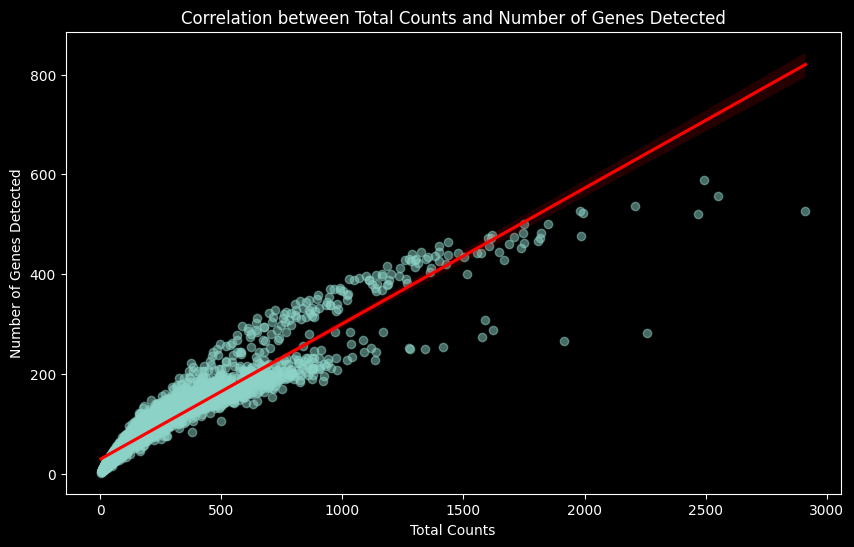

In [77]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(
    data=singlet_only_ctrl1.obs,
    x="total_counts",
    y="n_genes_by_counts",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
)
plt.xlabel("Total Counts")
plt.ylabel("Number of Genes Detected")
plt.title("Correlation between Total Counts and Number of Genes Detected")
plt.show()

In [78]:
singlet_only_ctrl1 = singlet_only_ctrl1[
    singlet_only_ctrl1.obs.pct_counts_is_mito_gene < 20
]
singlet_only_ctrl1 = singlet_only_ctrl1[
    singlet_only_ctrl1.obs.pct_counts_is_ribo_gene < 2
]
singlet_only_ctrl1

View of AnnData object with n_obs × n_vars = 4325 × 2000
    obs: '_scvi_batch', '_scvi_labels', 'n_genes_by_counts', 'total_counts', 'total_counts_is_mito_gene', 'pct_counts_is_mito_gene', 'total_counts_is_ribo_gene', 'pct_counts_is_ribo_gene', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'is_mito_gene', 'is_ribo_gene', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'

### Normalization

This step eliminates [sequencing biases](https://onlinelibrary.wiley.com/doi/10.1155/2021/6647597).

In [ ]:
sc.pp.normalize_total(singlet_only_ctrl1, target_sum=1e4) # 
singlet_only_ctrl1.X.sum(axis=1)

/var/folders/ff/4kc7g2h15bs_kbkzfbs381r00000gn/T/ipykernel_41038/3477128766.py:1: UserWarning: Received a view of an AnnData. Making a copy.
  sc.pp.normalize_total(singlet_only_ctrl1, target_sum=1e4)


array([10000., 10000., 10000., ..., 10000., 10000., 10000.],
      shape=(4325,), dtype=float32)

In [88]:
sc.pp.log1p(singlet_only_ctrl1)
singlet_only_ctrl1.X.sum(axis=1)

array([1306.34   , 1307.9111 ,  815.391  , ...,  228.81818,  128.51732,
        307.66254], shape=(4325,), dtype=float32)

In [90]:
sc.pp.regress_out(
    singlet_only_ctrl1,
    ["total_counts", "pct_counts_is_mito_gene", "pct_counts_is_ribo_gene"],
)
sc.pp.scale(singlet_only_ctrl1, max_value=10)
sc.pp.pca(singlet_only_ctrl1)

/Users/amkhrjee/Developer/covid-lung-atlas/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:657: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
/Users/amkhrjee/Developer/covid-lung-atlas/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:657: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff


In [96]:
sc.pp.neighbors(singlet_only_ctrl1, n_pcs=30)
singlet_only_ctrl1

AnnData object with n_obs × n_vars = 4325 × 2000
    obs: '_scvi_batch', '_scvi_labels', 'n_genes_by_counts', 'total_counts', 'total_counts_is_mito_gene', 'pct_counts_is_mito_gene', 'total_counts_is_ribo_gene', 'pct_counts_is_ribo_gene', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'is_mito_gene', 'is_ribo_gene', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'log1p', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [97]:
sc.tl.umap(singlet_only_ctrl1)

In [99]:
sc.tl.leiden(singlet_only_ctrl1, resolution=0.5)


/var/folders/ff/4kc7g2h15bs_kbkzfbs381r00000gn/T/ipykernel_41038/3303510938.py:1: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(singlet_only_ctrl1, resolution=0.5)


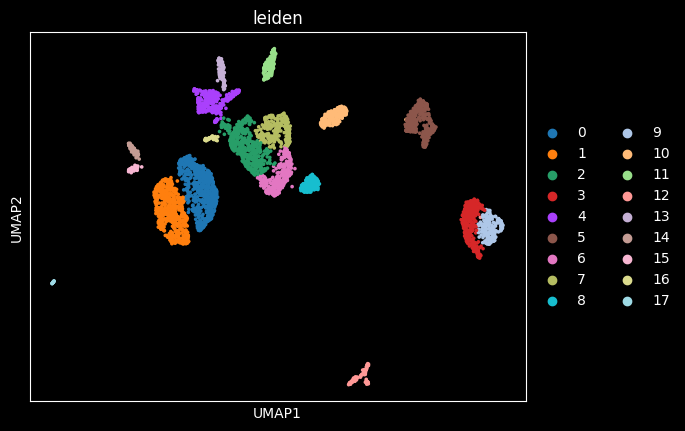

In [101]:
sc.pl.umap(singlet_only_ctrl1, color=["leiden"])